In [1]:
!pip install torch --index-url https://download.pytorch.org/whl/cu121
!pip install datasets tokenizers structlog tqdm utils

import utils
import math, random, time
from dataclasses import dataclass
import json
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders
from tqdm import tqdm
import structlog

Looking in indexes: https://download.pytorch.org/whl/cu121
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.6 MB/s eta 0:00:00
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=d670d133372189834dd4f76435ade33efdc976bd9c681e9b6ba00efbb9d70ee1
  Stored in directory: /root/.cache/pip/wheels/b6/a1/81/1036477786ae0e17b522f6f5a838f9bc4288d1016fc5d0e1ec
Successfully built utils


In [ ]:
# CODE ADDED BY ME
from torch.nn import RMSNorm

#Plotting the loss will allow us to nicely display the loss in a Jupyter Book.
loss_tracker = []

# Add different optimiser, which is better suited for transformer models
def get_optimizer(model, args):
    return torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, betas=args.betas)

# Add learning rate scheduler (currently still the same as before)
def get_scheduler(opt):
  return torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_steps)

# Use RMSNorm instead of LayerNorm - more efficient for transformer models
def get_norm(d_model):
  return RMSNorm(d_model)

# RoPE implementation, allows the model to better capture positional information
def apply_rope(x):
    # x shape: (B, n_head, T, head_dim)
    B, H, T, D = x.shape
    half = D // 2

    # Split into two halves
    x1 = x[..., :half]
    x2 = x[..., half:]

    # Create rotation frequencies
    theta = 1.0 / (10000 ** (torch.arange(0, half, device=x.device) / half))
    pos = torch.arange(T, device=x.device).unsqueeze(1)

    # Compute angles
    angle = pos * theta  # (T, half)

    cos = angle.cos()[None, None, :, :]   # (1,1,T,half)
    sin = angle.sin()[None, None, :, :]   # (1,1,T,half)

    # Apply rotation
    x_rotated = torch.cat([x1 * cos - x2 * sin,
                           x1 * sin + x2 * cos], dim=-1)
    return x_rotated

# CODE FROM GITHUB
@dataclass
class Hyperparameters:
    block_size: int = 128
    batch_size: int = 64
    vocab_size: int = 32_000
    n_layer = 4
    n_head  = 4
    d_model = 512
    dropout: float = 0.1
    lr = 5e-4                   #lr: float = 6e-3, decreased
    weight_decay: float = 0.1
    evals_per_epoch: int = 3
    betas = (0.9, 0.99)         # Added betas (increased)

    epochs: int = 7
    seed: int = 1337
    num_titles: int = 100_000
    val_frac: float = 0.10
    log_file: str = "./logs/mainrun.log"

def configure_logging(log_file: str):
    Path(log_file).parent.mkdir(parents=True, exist_ok=True)

    file_handler = open(log_file, 'w')

    structlog.configure(
        processors=[
            structlog.stdlib.filter_by_level,
            structlog.stdlib.add_logger_name,
            structlog.stdlib.add_log_level,
            structlog.stdlib.PositionalArgumentsFormatter(),
            structlog.processors.TimeStamper(fmt="iso"),
            structlog.processors.StackInfoRenderer(),
            structlog.processors.format_exc_info,
            structlog.processors.UnicodeDecoder(),
            structlog.processors.JSONRenderer()
        ],
        context_class=dict,
        logger_factory=structlog.stdlib.LoggerFactory(),
        cache_logger_on_first_use=True,
    )

    class DualLogger:
        def __init__(self, file_handler):
            self.file_handler = file_handler
            self.logger = structlog.get_logger()

        def log(self, event, **kwargs):
            log_entry = json.dumps({"event": event, "timestamp": time.time(), **kwargs})
            self.file_handler.write(log_entry + "\n")
            self.file_handler.flush()

            if kwargs.get("prnt", True):
                if "step" in kwargs and "max_steps" in kwargs:
                    tqdm.write(f"[{kwargs.get('step'):>5}/{kwargs.get('max_steps')}] {event}: loss={kwargs.get('loss', 'N/A'):.6f} time={kwargs.get('elapsed_time', 0):.2f}s")
                else:
                    parts = [f"{k}={v}" for k, v in kwargs.items() if k not in ["prnt", "timestamp"]]
                    if parts:
                        tqdm.write(f"{event}: {', '.join(parts)}")
                    else:
                        tqdm.write(event)

    return DualLogger(file_handler)

logger = None

def get_titles(num_titles: int, seed: int, val_frac: float) -> str:
    ds = load_dataset("julien040/hacker-news-posts", split="train", cache_dir="./data").shuffle(seed=seed)
    titles = [row["title"].strip() for row in ds.take(num_titles)]
    n = int(num_titles * (1 - val_frac))
    return titles[:n], titles[n:]

def get_batch(split_ids: torch.Tensor, ptr: int, block_size: int, batch_size: int, device: torch.device):
    span = block_size * batch_size + 1
    if ptr + span >= len(split_ids):
        ptr = 0
    batch = split_ids[ptr: ptr + span]
    x = batch[:-1].view(batch_size, block_size).to(device)
    y = batch[1:].view(batch_size, block_size).to(device)
    return x, y, ptr + block_size * batch_size

def iter_full_split(split_ids: torch.Tensor, block_size: int, batch_size: int, device: torch.device):
    span = block_size * batch_size + 1
    for ptr in range(0, len(split_ids) - span + 1, span):
        batch = split_ids[ptr: ptr + span]
        x = batch[:-1].view(batch_size, block_size).to(device)
        y = batch[1:].view(batch_size, block_size).to(device)
        yield x, y

def train_tokenizer(titles: list[str], vocab_size: int, unk_token: str = "<unk>", pad_token: str = "<pad>", eos_token: str = "<eos>") -> Tokenizer:
    tokenizer = Tokenizer(models.BPE(unk_token=unk_token))
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
    tokenizer.decoder = decoders.ByteLevel()
    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=[pad_token, eos_token, unk_token]
    )
    tokenizer.train_from_iterator(titles, trainer)
    return tokenizer

class BPETokenizer:
    def __init__(self, tokenizer: Tokenizer):
        self.tk = tokenizer
        self.stoi = {tok: i for tok, i in tokenizer.get_vocab().items()}
        self.itos = {i: tok for tok, i in tokenizer.get_vocab().items()}

    def encode(self, s: str) -> list[int]:
        return self.tk.encode(s).ids

    def decode(self, ids: list[int]) -> str:
        return self.tk.decode(ids, skip_special_tokens=True)

    @property
    def vocab_size(self): return self.tk.get_vocab_size()

@dataclass
class GPTConfig:
    vocab_size: int
    block_size: int
    n_layer: int
    n_head: int
    d_model: int
    dropout: float

class CausalSelfAttention(nn.Module):
    def __init__(self, cfg: GPTConfig):
        super().__init__()
        assert cfg.d_model % cfg.n_head == 0
        self.head_dim = cfg.d_model // cfg.n_head
        self.n_head   = cfg.n_head
        self.qkv = nn.Linear(cfg.d_model, 3 * cfg.d_model)
        self.proj = nn.Linear(cfg.d_model, cfg.d_model)
        self.attn_drop = nn.Dropout(cfg.dropout)
        self.resid_drop= nn.Dropout(cfg.dropout)
        self.register_buffer("tril", torch.tril(torch.ones(cfg.block_size, cfg.block_size)))

    def forward(self, x: torch.Tensor):
        B, T, C = x.size()
        qkv = self.qkv(x).view(B, T, 3, self.n_head, self.head_dim).transpose(1, 3)
        q, k, v = qkv[..., 0, :, :], qkv[..., 1, :, :], qkv[..., 2, :, :]
        q = apply_rope(q)
        k = apply_rope(k)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.resid_drop(self.proj(y))

class MLP(nn.Module):
    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(cfg.d_model, 8 * cfg.d_model),
            nn.GELU(),
            nn.Linear(8 * cfg.d_model, cfg.d_model),
            nn.Dropout(cfg.dropout),
        )
    def forward(self, x): return self.net(x)

class Block(nn.Module):
    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.ln1 = get_norm(cfg.d_model)
        self.ln2 = get_norm(cfg.d_model)
        self.attn = CausalSelfAttention(cfg)
        self.mlp  = MLP(cfg)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.cfg = cfg
        self.token_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb   = nn.Parameter(torch.zeros(1, cfg.block_size, cfg.d_model))
        self.drop      = nn.Dropout(cfg.dropout)
        self.blocks    = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layer)])
        self.ln_f      = get_norm(cfg.d_model)
        self.head      = nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)

        self.apply(self._init_weights)
        self.head.weight = self.token_emb.weight

    @staticmethod
    def _init_weights(module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor | None = None):
        B, T = idx.size()
        tok = self.token_emb(idx)
        pos = self.pos_emb[:, :T, :]
        x = self.drop(tok + pos)
        for block in self.blocks: x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), reduction='mean')
        return logits, loss

args = Hyperparameters()
torch.manual_seed(args.seed)
random.seed(args.seed)

global logger
logger = configure_logging(args.log_file)

hyperparams_dict = vars(args)
logger.log("hyperparameters_configured", **hyperparams_dict)

device = "cuda" if torch.cuda.is_available() else "cpu"
logger.log("device_info", device=device)

train_titles, val_titles = get_titles(args.num_titles, args.seed, args.val_frac)

eos_token = "<eos>"
tok = BPETokenizer(train_tokenizer(train_titles+val_titles, args.vocab_size, eos_token=eos_token))
train_text = eos_token.join(train_titles) + eos_token
val_text = eos_token.join(val_titles) + eos_token
train_ids = torch.tensor(tok.encode(train_text), dtype=torch.long)
val_ids = torch.tensor(tok.encode(val_text), dtype=torch.long)

batches = len(train_ids) // (args.block_size * args.batch_size)
max_steps = args.epochs * batches
eval_interval = batches // args.evals_per_epoch
logger.log("dataset_info",
            titles_count=len(train_titles),
            epochs=args.epochs,
            batches_per_epoch=batches,
            tokens_per_epoch=len(train_ids),
            vocab_size=tok.vocab_size)

cfg = GPTConfig(
    vocab_size = tok.vocab_size,
    block_size = args.block_size,
    n_layer    = args.n_layer,
    n_head     = args.n_head,
    d_model    = args.d_model,
    dropout    = args.dropout,
)
model = GPT(cfg).to(device)
model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.log("model_info", parameters_count=model_params)

opt = get_optimizer(model, args)
scheduler = get_scheduler(opt)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_steps)

def evaluate():
    model.eval()
    losses = 0.0
    with torch.no_grad():
        for xb, yb in iter_full_split(val_ids, args.block_size, args.batch_size, device):
            logits, _ = model(xb, yb)
            B, T, V = logits.size()
            loss = F.cross_entropy(logits.view(-1, V), yb.view(-1), reduction='sum')
            losses += loss.item()
    model.train()
    return losses / len(val_text)

ptr = 0
step = 0
t0 = time.time()
for epoch in range(1, args.epochs + 1):
    for _ in tqdm(range(1, batches + 1), desc=f"Epoch {epoch}/{args.epochs}"):
        step += 1
        xb, yb, ptr = get_batch(train_ids, ptr, args.block_size, args.batch_size, device)
        _, loss = model(xb, yb)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        scheduler.step()

        elapsed = time.time() - t0
        logger.log("training_step",
                  step=step,
                  max_steps=max_steps,
                  loss=loss.item(),
                  elapsed_time=elapsed,
                  prnt=False)

        if step == 1 or step % eval_interval == 0 or step == max_steps:
            val_loss = evaluate()
            loss_tracker.append(val_loss) # Line added by me
            logger.log("validation_step",
                      step=step,
                      max_steps=max_steps,
                      loss=val_loss,
                      elapsed_time=elapsed)

hyperparameters_configured: block_size=128, batch_size=64, vocab_size=32000, dropout=0.1, weight_decay=0.1, evals_per_epoch=3, epochs=7, seed=1337, num_titles=100000, val_frac=0.1, log_file=./logs/mainrun.log
device_info: device=cuda
dataset_info: titles_count=90000, epochs=7, batches_per_epoch=123, tokens_per_epoch=1014526, vocab_size=32000
model_info: parameters_count=37452288


Epoch 1/7:   1%|          | 1/123 [00:03<07:00,  3.45s/it]

[    1/861] validation_step: loss=1.917966 time=0.03s


Epoch 1/7:  33%|███▎      | 41/123 [00:32<02:08,  1.56s/it]

[   41/861] validation_step: loss=1.521273 time=28.56s


Epoch 1/7:  67%|██████▋   | 82/123 [01:01<01:01,  1.49s/it]

[   82/861] validation_step: loss=1.468171 time=57.75s


Epoch 1/7: 100%|██████████| 123/123 [01:29<00:00,  1.37it/s]


[  123/861] validation_step: loss=1.423354 time=86.34s


Epoch 2/7:  33%|███▎      | 41/123 [00:29<02:04,  1.52s/it]

[  164/861] validation_step: loss=1.390407 time=115.37s


Epoch 2/7:  67%|██████▋   | 82/123 [00:58<01:01,  1.51s/it]

[  205/861] validation_step: loss=1.358058 time=144.42s


Epoch 2/7: 100%|██████████| 123/123 [01:27<00:00,  1.41it/s]


[  246/861] validation_step: loss=1.334466 time=173.36s


Epoch 3/7:  33%|███▎      | 41/123 [00:28<02:03,  1.51s/it]

[  287/861] validation_step: loss=1.322137 time=202.30s


Epoch 3/7:  67%|██████▋   | 82/123 [00:57<01:02,  1.51s/it]

[  328/861] validation_step: loss=1.307110 time=231.34s


Epoch 3/7: 100%|██████████| 123/123 [01:27<00:00,  1.41it/s]


[  369/861] validation_step: loss=1.293728 time=260.42s


Epoch 4/7:  33%|███▎      | 41/123 [00:29<02:04,  1.52s/it]

[  410/861] validation_step: loss=1.288369 time=289.57s


Epoch 4/7:  67%|██████▋   | 82/123 [00:58<01:02,  1.51s/it]

[  451/861] validation_step: loss=1.278972 time=318.66s


Epoch 4/7: 100%|██████████| 123/123 [01:27<00:00,  1.41it/s]


[  492/861] validation_step: loss=1.272951 time=347.71s


Epoch 5/7:  33%|███▎      | 41/123 [00:29<02:04,  1.51s/it]

[  533/861] validation_step: loss=1.268952 time=376.79s


Epoch 5/7:  67%|██████▋   | 82/123 [00:58<01:02,  1.52s/it]

[  574/861] validation_step: loss=1.263219 time=405.87s


Epoch 5/7: 100%|██████████| 123/123 [01:27<00:00,  1.41it/s]


[  615/861] validation_step: loss=1.258249 time=434.99s


Epoch 6/7:  33%|███▎      | 41/123 [00:29<02:04,  1.52s/it]

[  656/861] validation_step: loss=1.256839 time=464.10s


Epoch 6/7:  67%|██████▋   | 82/123 [00:58<01:02,  1.51s/it]

[  697/861] validation_step: loss=1.255772 time=493.21s


Epoch 6/7: 100%|██████████| 123/123 [01:27<00:00,  1.41it/s]


[  738/861] validation_step: loss=1.252785 time=522.29s


Epoch 7/7:  33%|███▎      | 41/123 [00:29<02:04,  1.51s/it]

[  779/861] validation_step: loss=1.253220 time=551.34s


Epoch 7/7:  67%|██████▋   | 82/123 [00:58<01:02,  1.51s/it]

[  820/861] validation_step: loss=1.252682 time=580.36s


Epoch 7/7: 100%|██████████| 123/123 [01:27<00:00,  1.41it/s]

[  861/861] validation_step: loss=1.252463 time=609.39s



[CONTEXT up to t=80]
 Motorola Xoom commercial reminiscent of Apple's infamous jab at IBM<eos> OpenSSH Key Shielding<eos> Contextual Word Representations: A Contextual Introduction (2020)<eos> Windows 8 Should Be Free<eos> GNOME Developers Lay Out Plans for GNOME OS<eos> HTML/CSS/JS Art Hacks<eos> Major Electrical Outtage at The Planet Data Center<eos> South Africa’s Umhlanga Rocks may attract investors<eos>

Top-10 predictions at t = 80
1. p=0.0639 | id=269 | ' The'
2. p=0.0441 | id=347 | ' Ask'
3. p=0.0385 | id=322 | ' How'
4. p=0.0325 | id=378 | ' Show'
5. p=0.0233 | id=205 | ' A'
6. p=0.0186 | id=417 | ' Why'
7. p=0.0149 | id=392 | ' What'
8. p=0.0107 | id=406 | ' Google'
9. p=0.0077 | id=411 | ' New'
10. p=0.0074 | id=532 | ' Apple'


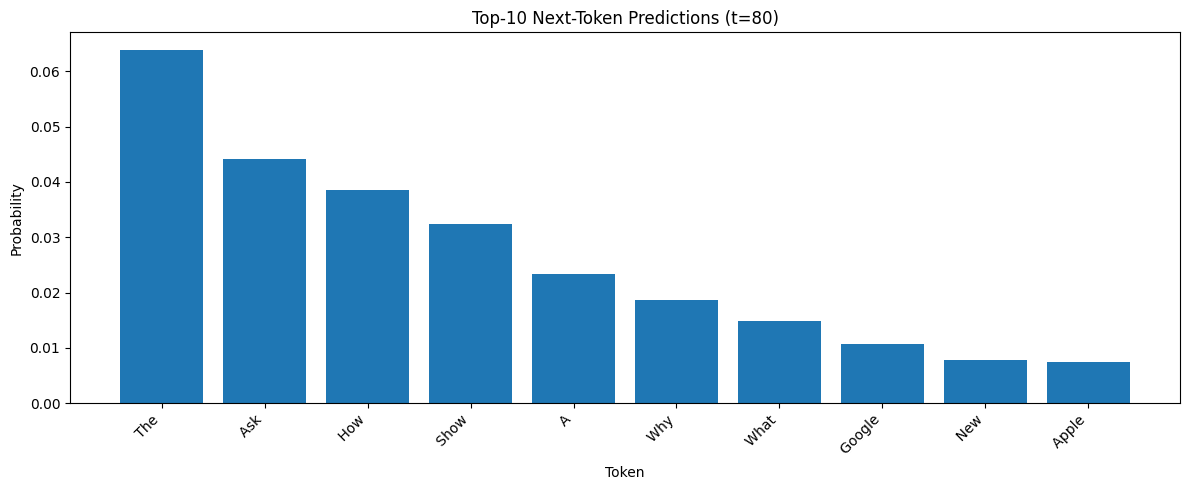

In [18]:
# |label: token_evaluate_frequency_step_two
import matplotlib.pyplot as plt

def evaluate_visualise():
    model.eval()
    losses = 0.0

    with torch.no_grad():
        for xb, yb in iter_full_split(val_ids, args.block_size, args.batch_size, device):

            logits, _ = model(xb, yb)

            b = 0 # batch
            t = 80  # timestep

            probs = torch.softmax(logits[b], dim=-1)   # (T, V) out


            # displat context
            prefix_ids = xb[b, :t+1].tolist()
            prefix_str = tok.tk.decode(prefix_ids, skip_special_tokens=False)
            print(f"\n[CONTEXT up to t={t}]")
            print(prefix_str)

            top_probs, top_ids = probs[t].topk(10)

            # decode token strings
            decoded_tokens = [tok.tk.decode([tid.item()], skip_special_tokens=False) for tid in top_ids ]

            # Print for debugging
            print("\nTop-10 predictions at t =", t)
            for rank in range(10):
                print(f"{rank+1}. p={top_probs[rank].item():.4f} | id={top_ids[rank].item()} | '{decoded_tokens[rank]}'")

            # plt histogram
            plt.figure(figsize=(12, 5))
            plt.bar(decoded_tokens, top_probs.cpu().tolist())
            plt.title(f"Top-10 Next-Token Predictions (t={t})")
            plt.xlabel("Token")
            plt.ylabel("Probability")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            break  # only first batch
evaluate_visualise()

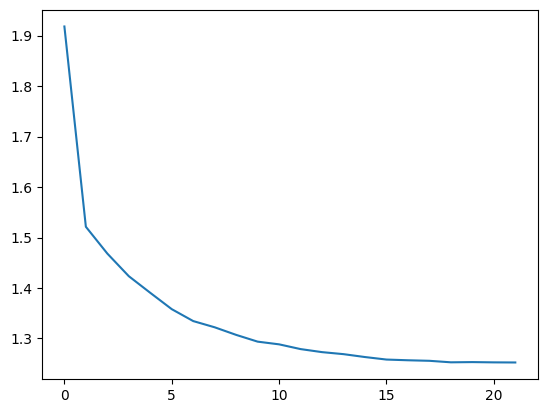

In [15]:
# |label: output-second-step
import matplotlib.pyplot as plt

plt.plot(loss_tracker)
plt.show()